In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython.display import Image, display
import matplotlib.cm as cm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

# LIME algorithm

#### LIME Algorithm Reference Link:  __https://github.com/marcotcr/lime__

In [2]:
%load_ext autoreload
%autoreload 2
import os,sys
try:
    import lime
except:
    sys.path.append(os.path.join('..', '..')) # add the current directory
    import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
explainer = lime_image.LimeImageExplainer()

c:\users\emily\appdata\local\programs\python\python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# LIME explanation method visualizes the contribution of each feature of an image to the model’s classification

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:08<00:00, 14.64it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:09<00:00, 14.37it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


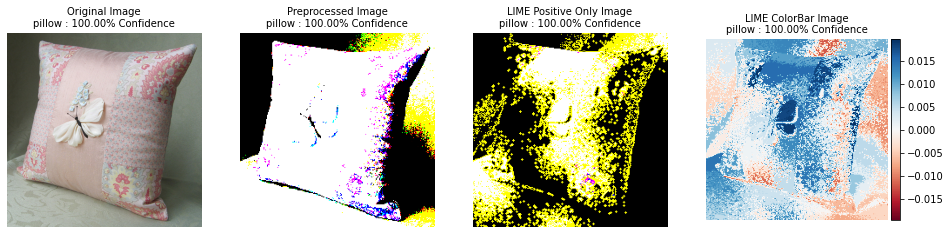

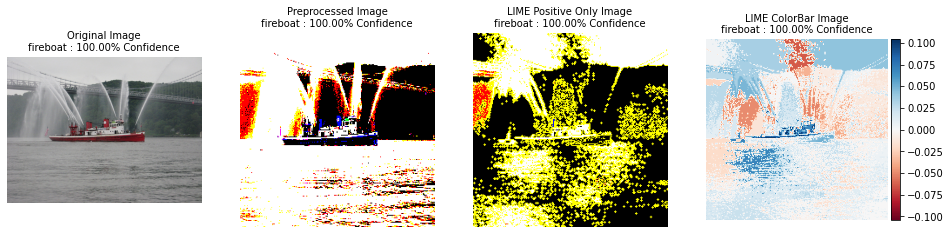

In [3]:
%%time
files = ['8.png','9.png']
image_title = '9_results.png'
for internal_img in files:
    ## Preprocess image
    img_path = internal_img # img_path = "1.png"
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)


    ## Prediction of Image        
    model_ResNet50 = ResNet50()
    preds = model_ResNet50.predict(x)
    a =  decode_predictions(preds, top=1)[0][0] #<=== get the prediction class name and predictive score


    sys.stdout = open(os.devnull, 'w') #< ==== Disable printing the steps
    # Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
    explanation = explainer.explain_instance(x[0].astype('double'), model_ResNet50.predict, top_labels=5, hide_color=0, num_samples=1000)
    sys.stdout = sys.__stdout__ # < ==== Restore printing


    ## Get the image and the mask of the image
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=50, hide_rest=True)
    #plt.imshow(mark_boundaries(temp, mask))
    

    ## Colorbar HeatMap
    #Select the same class explained on the figures above.
    ind =  explanation.top_labels[0]
    #Map each explanation weight to the corresponding superpixel
    dict_heatmap = dict(explanation.local_exp[ind])
    heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 


    fig, axs = plt.subplots(1, 4, figsize=(16, 8))
    axs[0].imshow(mpimg.imread(img_path))
    axs[0].axis('off')
    axs[0].set_title('Original Image\n{} : {:.2f}% Confidence'.format( a[1], a[2]*100), fontsize=10)
    axs[1].imshow(np.vstack(x))
    axs[1].axis('off')
    axs[1].set_title('Preprocessed Image\n{} : {:.2f}% Confidence'.format( a[1], a[2]*100), fontsize=10)
    axs[2].imshow(mark_boundaries(temp , mask))
    axs[2].axis('off')
    axs[2].set_title('LIME Positive Only Image\n{} : {:.2f}% Confidence'.format( a[1], a[2]*100), fontsize=10)

    
    #Plot. The visualization makes more sense if a symmetrical colorbar is used.
    im = axs[3].imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
    axs[3].axis('off')
    axs[3].set_title('LIME ColorBar Image\n{} : {:.2f}% Confidence'.format( a[1], a[2]*100), fontsize=10)
    
    
    #fig.colorbar(im, ax=axs[3])
    divider = make_axes_locatable(axs[3])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax)
    #plt.colorbar()    
    #fig.savefig(image_title, bbox_inches="tight") #<- Uncomment